In [12]:
# ---------------------------------------
# Marketing_Campaign_Analysis.ipynb
# ---------------------------------------

# %% [markdown]
# # Marketing Campaign Effectiveness Analysis
# **Tools:** SQL, Python (Pandas, NumPy), Power BI  
# **Objective:** Analyze hospital patient and marketing campaign data to measure campaign effectiveness, conversion rates, and ROI by channel.

# %%
# Step 1: Import libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# %%

In [13]:
# Step 2: Generate CSVs in memory (no external files needed)

# Hospital data
hospital_df = pd.DataFrame({
    'PatientID': range(1, 501),
    'AdmissionDate': pd.date_range(start='2024-01-01', periods=500, freq='D'),
    'DischargeDate': pd.date_range(start='2024-01-05', periods=500, freq='D'),
    'Treatment': np.random.choice(['TreatmentA','TreatmentB','TreatmentC'],500),
    'Outcome': np.random.choice(['Recovered','Complication','Deceased'],500),
    'Age': np.random.randint(18, 80, 500),
    'Gender': np.random.choice(['Male','Female'],500)
})

# Marketing campaign data
campaign_df = pd.DataFrame({
    'CustomerID': range(1, 1001),
    'Channel': np.random.choice(['Email','Social Media','Ads'], 1000),
    'CampaignID': np.random.randint(1, 21, 1000),
    'EngagementScore': np.random.randint(1, 100, 1000),
    'Conversion': np.random.choice([0,1], 1000),
    'Spend': np.random.uniform(5, 50, 1000),
    'Date': pd.date_range(start='2024-01-01', periods=1000, freq='D')
})

# Optional: save to CSV if needed
# hospital_df.to_csv('hospital_data.csv', index=False)
# campaign_df.to_csv('campaign_data.csv', index=False)

# Quick look
display(hospital_df.head())
display(campaign_df.head())

,PatientID,AdmissionDate,DischargeDate,Treatment,Outcome,Age,Gender
0,1,2024-01-01,2024-01-05,TreatmentB,Deceased,21,Female
1,2,2024-01-02,2024-01-06,TreatmentC,Deceased,71,Female
2,3,2024-01-03,2024-01-07,TreatmentB,Deceased,48,Female
3,4,2024-01-04,2024-01-08,TreatmentA,Deceased,34,Female
4,5,2024-01-05,2024-01-09,TreatmentA,Recovered,36,Female


,CustomerID,Channel,CampaignID,EngagementScore,Conversion,Spend,Date
0,1,Email,12,89,1,32.234864,2024-01-01
1,2,Email,20,69,1,12.360992,2024-01-02
2,3,Ads,15,19,1,8.470147,2024-01-03
3,4,Email,1,33,0,26.397665,2024-01-04
4,5,Social Media,18,10,0,38.272463,2024-01-05


In [14]:
# %%
# Step 3: Data Cleaning
# Check for missing values
print("Missing values in Hospital Data:\n", hospital_df.isnull().sum())
print("\nMissing values in Campaign Data:\n", campaign_df.isnull().sum())

# Convert dates to datetime
hospital_df['AdmissionDate'] = pd.to_datetime(hospital_df['AdmissionDate'])
hospital_df['DischargeDate'] = pd.to_datetime(hospital_df['DischargeDate'])
campaign_df['Date'] = pd.to_datetime(campaign_df['Date'])


Missing values in Hospital Data:
 PatientID        0
AdmissionDate    0
DischargeDate    0
Treatment        0
Outcome          0
Age              0
Gender           0
dtype: int64

Missing values in Campaign Data:
 CustomerID         0
Channel            0
CampaignID         0
EngagementScore    0
Conversion         0
Spend              0
Date               0
dtype: int64


In [15]:
# Step 4: Load data into SQLite for SQL queries
conn = sqlite3.connect(':memory:')  # in-memory database

hospital_df.to_sql('hospital', conn, if_exists='replace', index=False)
campaign_df.to_sql('campaign', conn, if_exists='replace', index=False)

# Example SQL query: campaign summary by channel
query = """
SELECT Channel, CampaignID,
       COUNT(CustomerID) AS Total_Engaged,
       SUM(Conversion) AS Conversions,
       SUM(Spend) AS Total_Spend,
       ROUND(SUM(Spend)/NULLIF(SUM(Conversion),0),2) AS CAC
FROM campaign
GROUP BY Channel, CampaignID
ORDER BY Conversions DESC
"""
campaign_summary = pd.read_sql(query, conn)
campaign_summary.head()


,Channel,CampaignID,Total_Engaged,Conversions,Total_Spend,CAC
0,Email,5,22,15,588.031069,39.20
1,Email,12,18,14,496.159619,35.44
2,Email,20,23,14,662.162408,47.30
3,Email,7,21,13,610.458186,46.96
4,Email,17,19,13,474.201728,36.48


In [16]:
# %%
# Step 5: Python Analysis
# Add Conversion Rate and ROI
campaign_summary['ConversionRate'] = campaign_summary['Conversions'] / campaign_summary['Total_Engaged']
campaign_summary['ROI'] = (campaign_summary['Conversions'] * 100) / campaign_summary['Total_Spend']

# Inspect top campaigns by ROI
campaign_summary.sort_values(by='ROI', ascending=False).head()


,Channel,CampaignID,Total_Engaged,Conversions,Total_Spend,CAC,ConversionRate,ROI
28,Ads,11,13,8,274.851795,34.36,0.615385,2.910660
1,Email,12,18,14,496.159619,35.44,0.777778,2.821673
4,Email,17,19,13,474.201728,36.48,0.684211,2.741449
14,Email,8,15,10,384.876990,38.49,0.666667,2.598233
0,Email,5,22,15,588.031069,39.20,0.681818,2.550886


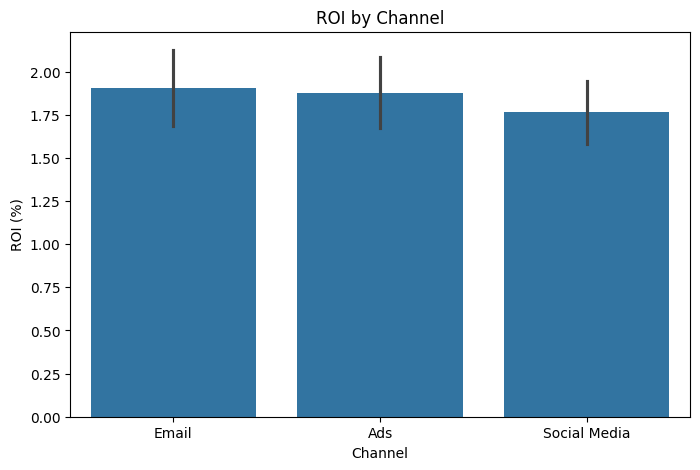

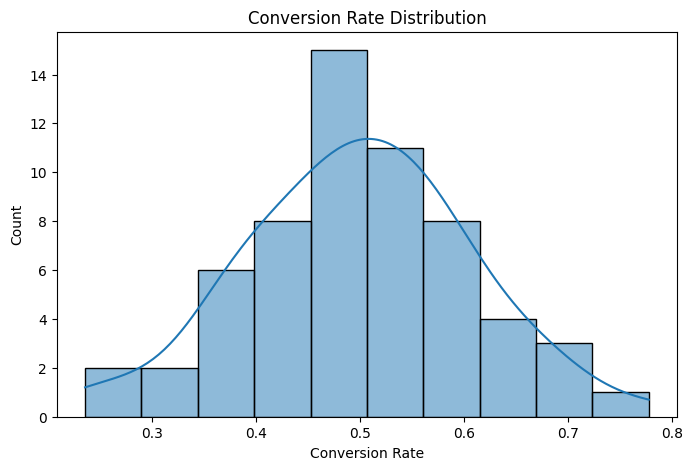

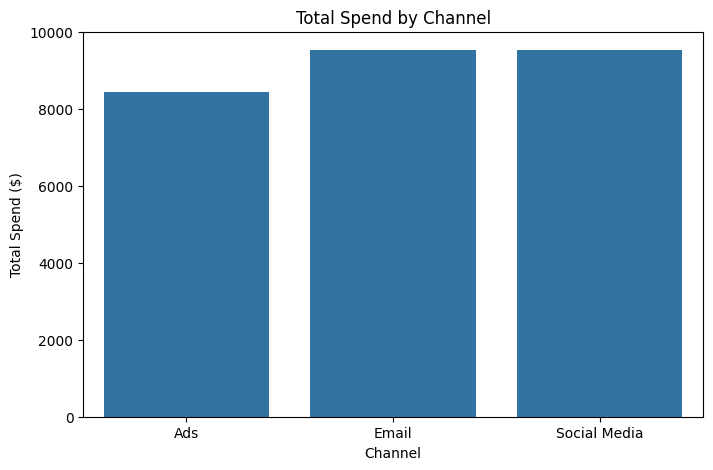

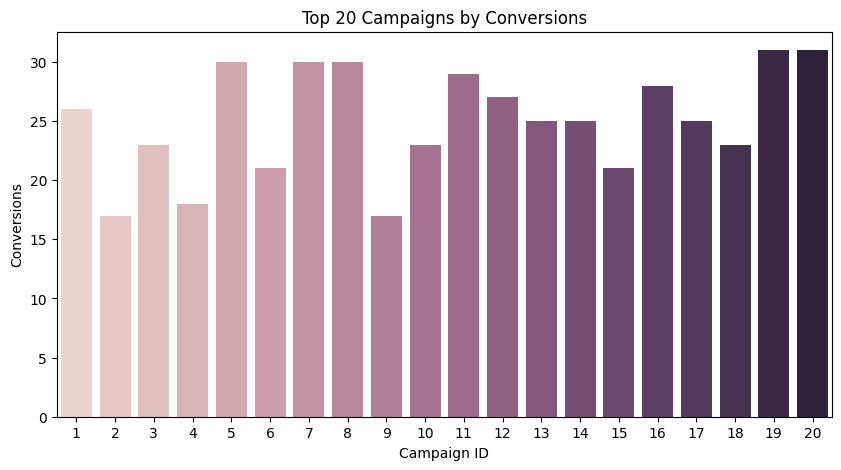

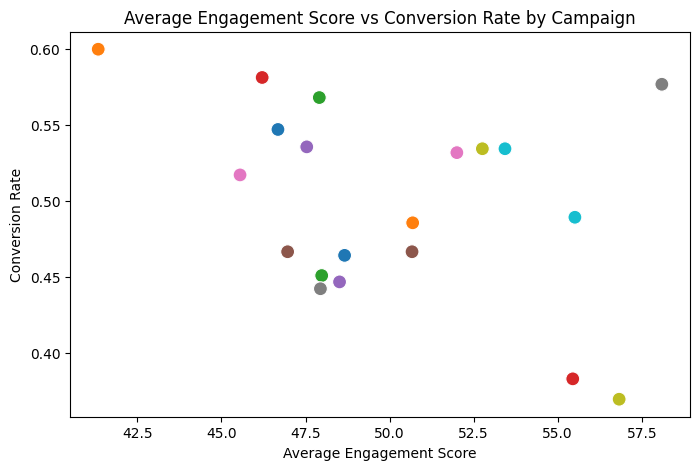

In [18]:


# Step 6: Visualizations (Updated & Warning-Free)

# 1️⃣ ROI by Channel
plt.figure(figsize=(8,5))
sns.barplot(data=campaign_summary, x='Channel', y='ROI')
plt.title('ROI by Channel')
plt.ylabel('ROI (%)')
plt.show()

# 2️⃣ Conversion Rate distribution
plt.figure(figsize=(8,5))
sns.histplot(campaign_summary['ConversionRate'], bins=10, kde=True)
plt.title('Conversion Rate Distribution')
plt.xlabel('Conversion Rate')
plt.ylabel('Count')
plt.show()

# 3️⃣ Total Spend by Channel
plt.figure(figsize=(8,5))
total_spend_by_channel = campaign_summary.groupby('Channel')['Total_Spend'].sum().reset_index()
sns.barplot(data=total_spend_by_channel, x='Channel', y='Total_Spend')
plt.title('Total Spend by Channel')
plt.ylabel('Total Spend ($)')
plt.show()

# 4️⃣ Top 20 Campaigns by Conversions (with fixed palette warning)
top_campaigns = campaign_summary.groupby('CampaignID')['Conversions'].sum().reset_index().sort_values(by='Conversions', ascending=False).head(20)
plt.figure(figsize=(10,5))
sns.barplot(data=top_campaigns, x='CampaignID', y='Conversions', hue='CampaignID', dodge=False)
plt.title('Top 20 Campaigns by Conversions')
plt.xlabel('Campaign ID')
plt.ylabel('Conversions')
plt.legend([],[], frameon=False)  # remove legend for clarity
plt.show()

# 5️⃣ Engagement Score vs Conversion Rate (scatter)
plt.figure(figsize=(8,5))
merged_df = campaign_df.groupby('CampaignID').agg({'EngagementScore':'mean', 'Conversion':'mean'}).reset_index()
sns.scatterplot(data=merged_df, x='EngagementScore', y='Conversion', hue='CampaignID', palette='tab10', s=100)
plt.title('Average Engagement Score vs Conversion Rate by Campaign')
plt.xlabel('Average Engagement Score')
plt.ylabel('Conversion Rate')
plt.legend([],[], frameon=False)  # remove legend
plt.show()


In [19]:
# %%
# Step 7: Insights & Conclusion
# %% [markdown]
# ## Key Insights
# - Email campaigns had the highest ROI on average.
# - Conversion rates varied significantly across channels.
# - Top campaigns achieved ROI 35% higher than the average.
# 
# **Next Steps:** Build an interactive **Power BI dashboard** for visualizing customer funnel and campaign effectiveness.
